In [ ]:
## cross-sectional plot of ualong for different regions at key transition times of ASC speed

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

In [2]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [5]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [6]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28

memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.29:44621,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60)).chunk({ 'yu_ocean':69, 'xu_ocean':360})
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<rechunk-merge, shape=(440, 3600), dtype=float32, chunksize=(69, 360), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(69, 360), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(69, 360), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [8]:
# location limits of dataset - choosing slice near totten
#lon_lim = slice(-270, -230) #slice(30, 45)#
lat_lim = slice(-79, -60) #slice(-70, -65)

hu_region = hu.sel( yu_ocean = lat_lim)

In [9]:

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthp


In [10]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'


In [11]:
ualong_decademean_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthmp + '.nc')
ualong_decademean_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthp + '.nc')
ualong_decademean_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_ctrl + '.nc')
ualong_decademean_wthmp

<xarray.Dataset> Size: 76MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 440, decade: 5)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
  * decade    (decade) int64 40B 0 1 2 3 4
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
Data variables:
    u_along   (decade, yu_ocean, xu_ocean) float64 63MB dask.array<chunksize=(5, 440, 3600), meta=np.ndarray>
Attributes:
    units:        m/s
    description:  Time-mean along slope velocity for each decade of MW exprim...

In [12]:
cd Antarctic-Eddy-Res-Compare

/home/561/qo9901/Antarctic-Eddy-Res-Compare


In [13]:
import cmocean
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [14]:
## importing masks for clusters

cluster_mask_access = xr.open_mfdataset('largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access

<xarray.Dataset> Size: 2MB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600)
Dimensions without coordinates: yu_ocean, xu_ocean
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean) bool 2MB dask.array<chunksize=(440, 3600), meta=np.ndarray>

In [15]:
mask_bath_slopeshelf = xr.where((hu_region <2600),True,False)

In [16]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -80


In [17]:
def changeline_cs(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('k')
        #col.set_linewidth(2)


## plot decade mean -  smaller than decade

In [32]:
levels_ualong = np.arange(-0.085,0.085,0.005)


In [ ]:
fig, ax = plt.subplots(nrows =4 ,figsize = (30,20))

# accessom2-01
cmap = (ualong_decademean_wthmp.u_along - ualong_decademean_wthp.u_along).isel(decade = 0)\
            .plot.contourf(levels = levels_ualong, add_colorbar = False, ax = ax[0])#cs = hu_region.where(hu_region < 2600).plot.contour(levels  = [2500], color = 'k', ax = ax[0])
#changeline_cs('solid')
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax[0], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')
ax[0].set_ylabel('')
ax[0].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].text(0.01,0.1,'Meltwater \nComponent Yr 10-20',transform=ax[0].transAxes)
ax[0].set_xlabel('')
ax[0].text(0.01,0.85,'(a)', transform=ax[0].transAxes, fontweight = 'bold')



cmap = (ualong_decademean_wthmp.u_along - ualong_decademean_wthp.u_along).isel(decade = 1)\
            .plot.contourf(levels = levels_ualong, add_colorbar = False, ax = ax[1])#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax[1], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax[1].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].set_ylim([-80,-60])
ax[1].text(0.01,0.1,'Meltwater \nComponent Yr 20-30',transform=ax[1].transAxes)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].text(0.01,0.85,'(b)', transform=ax[1].transAxes, fontweight = 'bold')

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax, pad = 0.1)
cbar.set_ticks(np.arange(-0.1,0.125,0.025))


cmap = (ualong_decademean_wthmp.u_along - ualong_decademean_wthp.u_along).isel(decade = 2)\
            .plot.contourf(levels =levels_ualong, add_colorbar = False, ax = ax[2])
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax[2], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax[2].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[2].set_ylim([-80,-60])
ax[2].text(0.01,0.1,'Meltwater \nComponent Yr 30-40',transform=ax[2].transAxes)
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].text(0.01,0.85,'(c)', transform=ax[2].transAxes, fontweight = 'bold')

cmap = (ualong_decademean_wthmp.u_along - ualong_decademean_wthp.u_along).isel(decade = 3)\
            .plot.contourf(levels =levels_ualong, add_colorbar = False, ax = ax[3])
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax[3], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax[3].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[3].set_ylim([-80,-60])
ax[3].text(0.01,0.1,'Meltwater \nComponent Yr 40-50',transform=ax[3].transAxes)
ax[3].set_ylabel('')
ax[3].set_xlabel('')
ax[3].text(0.01,0.85,'(d)', transform=ax[3].transAxes, fontweight = 'bold')

'''
cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, orientation = 'horizontal', cax = cb_ax, pad = 0.01)
#cbar.set_ticks([])
cbar.set_ticks(levels_ualong[1::4])
cbar.set_ticklabels([ round(elem, 2) for elem in levels_ualong[1::4] ])
'''

for box in range(3):
    ax[box].yaxis.set_major_formatter(LatitudeFormatter())
    ax[box].xaxis.set_major_formatter(LongitudeFormatter())


In [ ]:
## plotting along-slope velocity cross sections in key regions

In [21]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s

In [22]:
u_depth = cc.querying.getvar(expt,'u', session, frequency = '1 monthly').sel(yu_ocean = lat_lim)
v_depth = cc.querying.getvar(expt,'v', session, frequency = '1 monthly').sel(yu_ocean = lat_lim)

u_depth

<xarray.DataArray 'u' (time: 720, st_ocean: 75, yu_ocean: 440, xu_ocean: 3600)> Size: 342GB
dask.array<getitem, shape=(720, 75, 440, 3600), dtype=float32, chunksize=(1, 7, 250, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 6kB 2100-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [23]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [24]:
pwd

'/home/561/qo9901/Antarctic-Eddy-Res-Compare'

In [25]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))

In [26]:
## plotting everything together
cluster_mask_access = xr.open_mfdataset('largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', u.xu_ocean.data), yu_ocean = ('yu_ocean', u.yu_ocean.data))
#calculating area on shelf and slope total
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
#circ_area_slope = (area_u*cluster_mask_access.where(mask_slope ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
#circ_area_shelf = (area_u*cluster_mask_access.where(mask_shelf ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
#circ_area_total = (area_u*cluster_mask_access).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           


In [27]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [28]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [29]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [30]:
vel = xr.merge([hu,coordinates, u, v, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [31]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [32]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [33]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid
'''
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])
'''
# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(vel.hu, 'X') / grid.interp(vel.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(vel.hu, 'Y', boundary='extend') / grid.interp(vel.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_lim)
dhu_dy = dhu_dy.sel(yu_ocean=lat_lim)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [ ]:
u_yearmean = u.isel(time = slice(0,240)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
            .chunk({'yu_ocean':69, 'xu_ocean':360}).load()
v_yearmean = v.isel(time = slice(0,240)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
            .chunk({'yu_ocean':69, 'xu_ocean':360}).load()

u_yearmean

In [ ]:
# Along-slope velocity
u_along = u_yearmean * dhu_dy / topographic_slope_magnitude - v_yearmean * dhu_dx / topographic_slope_magnitude

# Load the data
u_along = u_along.load()

# Similarly, we can calculate the cross-slope velocity:
#v_cross = u*dhu_dx/topographic_slope_magnitude + v*dhu_dy/topographic_slope_magnitude

In [ ]:
expt

In [110]:
u_along.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_annualemean_' + expt + '.nc')

In [36]:
u_depth.coarsen(time=12).construct(time=('year', 'month')).mean('month')\
            .chunk({ 'xu_ocean':360})

<xarray.DataArray 'u' (year: 60, st_ocean: 75, yu_ocean: 440, xu_ocean: 3600)> Size: 29GB
dask.array<rechunk-merge, shape=(60, 75, 440, 3600), dtype=float32, chunksize=(1, 7, 250, 360), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Dimensions without coordinates: year

In [64]:
%%time
# Along-slope velocity with depth

udepth_yearmean = u_depth.isel(time = slice(0,12)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
            .chunk({'xu_ocean':360}).load()
vdepth_yearmean = v_depth.isel(time = slice(0,12)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
            .chunk({'xu_ocean':360}).load()

udepth_yearmean

CPU times: user 20.7 s, sys: 1.93 s, total: 22.7 s
Wall time: 22.9 s


<xarray.DataArray 'u' (year: 1, st_ocean: 75, yu_ocean: 440, xu_ocean: 3600)> Size: 475MB
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-0.00230605,  0.00375139,  0.01046457, ..., -0.0218646 ,
          -0.01436158, -0.00787654],
         [ 0.00233365,  0.00853692,  0.01509661, ..., -0.01556132,
          -0.00870841, -0.00310675],
         [ 0.0083039 ,  0.01411476,  0.01977816, ..., -0.00865192,
          -0.00247318,  0.00290833]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Dimensions without coordinates: year

In [65]:
u_alongdepth = udepth_yearmean * dhu_dy / topographic_slope_magnitude - vdepth_yearmean * dhu_dx / topographic_slope_magnitude

# Load the data
u_alongdepth = u_alongdepth.load()

In [35]:
tt = 2
'/g/data/v45/qo9901/MW-perturb-ASC-data/ualongdepth_annualmean_' + expt + f'_{tt:03d}.nc'

'/g/data/v45/qo9901/MW-perturb-ASC-data/ualongdepth_annualmean_01deg_jra55v13_ryf9091_qian_wthp_002.nc'

In [ ]:
u_depth.isel(time = slice(12 , (2)*12)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
                .chunk({'xu_ocean':360})#.xu_ocean

In [36]:

#u_alongdepth_arr = []
for tt in range(41,50):
    udepth_yearmean = u_depth.isel(time = slice(tt*12 , (tt+1)*12)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
                .chunk({'xu_ocean':360}).load()
    vdepth_yearmean = v_depth.isel(time = slice(tt*12 , (tt+1)*12)).coarsen(time=12).construct(time=('year', 'month')).mean('month')\
                .chunk({'xu_ocean':360}).load()
    u_alongdepth = udepth_yearmean * dhu_dy / topographic_slope_magnitude - vdepth_yearmean * dhu_dx / topographic_slope_magnitude

    # Load the data
    u_alongdepth = u_alongdepth.load()
    u_alongdepth = u_alongdepth.rename('ualong_depth').assign_coords({'year':u_alongdepth.year + tt})
    print(u_alongdepth)
    u_alongdepth.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/ualongdepth_annualmean_' + expt + f'_{tt:03d}.nc')
    del udepth_yearmean, vdepth_yearmean, u_alongdepth
    

<xarray.DataArray 'ualong_depth' (year: 1, st_ocean: 75, yu_ocean: 440,
                                  xu_ocean: 3600)> Size: 475MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.05634582, 0.04945421, 0.04552535, ..., 0.07326121,
          0.06793584, 0.06336476],
         [0.05154892, 0.04739177, 0.03847769, ..., 0.06639224,
          0.06042654, 0.05552717],
         [0.04574842, 0.04302467, 0.03162441, ..., 0.0532979 ,
          0.05408278, 0.04979539]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
  

## selecting cross sections

In [18]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/ualongdepth_annualmean_' + exp_wthmp + f'_{tt:03d}.nc' for tt in range(50)]
u_alongdepth_wthmp = xr.open_mfdataset(FileList, combine = 'by_coords')
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/ualongdepth_annualmean_' + exp_wthp + f'_{tt:03d}.nc' for tt in range(50)]
u_alongdepth_wthp = xr.open_mfdataset(FileList, combine = 'by_coords')
u_alongdepth_wthmp

<xarray.Dataset> Size: 24GB
Dimensions:       (st_ocean: 75, xu_ocean: 3600, yu_ocean: 440, year: 50)
Coordinates:
  * st_ocean      (st_ocean) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
  * xu_ocean      (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.9 80.0
  * yu_ocean      (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
  * year          (year) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    ualong_depth  (year, st_ocean, yu_ocean, xu_ocean) float32 24GB dask.array<chunksize=(1, 75, 440, 3600), meta=np.ndarray>

In [19]:
import cf_xarray as cf

In [20]:
from metpy.interpolate import cross_section
import pyproj

In [21]:
def centre_longitude(ds, centre=0, lonvar=None):
    """Wrap longitude to specified centre"""
   
    if lonvar is None:
        # Use cf_xarray to find longitude coordinate
        lonvar = ds.cf.coordinates['longitude'][0]

    upper_limit = centre + 180.
    print(ds.coords[lonvar])
    # Ensure coordinates are within range 0 -> 360
    ds.coords[lonvar] = ds.coords[lonvar] % 360.
    
    # Wrap all longitude locations above upper limit and re-sort by longitude
    ds.coords[lonvar] = xr.where(ds.coords[lonvar] > upper_limit, 
                                 ds.coords[lonvar] - 360., 
                                 ds.coords[lonvar])
    print(ds[lonvar])

    ds = ds.sortby(ds[lonvar])
    
    return ds

In [55]:
plot_coord_list = ((-70, 38.5+100,-66, 38.5+100), #-70, 38.5+100,-65, 38.5+100)
                   (-70, 75+100, -65, 75+100),
                   (-71, 23.5+100,-65, 23.5+100),
                   (-78, -55.5+100,-70, -38.5+100),#(-80, -55.5+100,-70, -38.5+100)
                   (-79, -186.5+100,-68,  -180.5+100), #(-80, 173.5+100,-68,  180.5+100)
                   (-68,  -163.5,-63,  -166.5), # (-68,  143.5+100,-63,  146.5+100)
                   (-72.5,-96.5+100,-68,  -99.5+100), #(-73,-96.5+100,-68,  -99.5+100)
                   (-70, -66.5+100,-65, -80.5+100),
                   (-73, -81.5+100,-68, -85.5+100))
plot_coord_list_test = np.array(plot_coord_list)
for l in np.arange(0,len(plot_coord_list)):
    plot_coord_list_test[l,1] = plot_coord_list[l][1]-100
    plot_coord_list_test[l,3] = plot_coord_list[l][3]-100

#select l for coord   
l = 0
shelf_coord = plot_coord_list_test[l][:2]
deep_coord = plot_coord_list_test[l][2:]
shelf_coord = plot_coord_list[l][:2]
deep_coord = plot_coord_list[l][2:]

In [23]:
lat_lim

slice(-79, -60, None)



Vertical averaging (we only need this to plot the velocity on a map)

In [24]:
# Import edges of st_ocean and add lat/lon dimensions:  , start_time=start_time_mw, end_time=end_time_mw,
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1, 2])

In [25]:

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
#u_barotrop"ic = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')
#v_barotropic = (v_cross * thickness).sum('st_ocean') / thickness.sum('st_ocean')

In [26]:
def generate_cross_section(u_along, shelf_coord, deep_coord):
    # Create dataset
    ds = xr.Dataset({"u_along": u_along.ualong_depth, "lat": hu.yu_ocean, "lon": hu.xu_ocean, "hu": hu})
    # Rename coordinate names
    ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'}).drop(['geolat_c', 'geolon_c', 'year'])
    ## NEED TO DROP TIME
    
    # Centre on zero longitude as this is what metpy requires
    ds = centre_longitude(ds, lonvar = 'x')
    
    #ds['x'] = ds['x']+100
    ds['x'].attrs = u_along['xu_ocean'].attrs ## NEED TO ADD ATTRS
    ds['y'].attrs = u_along['yu_ocean'].attrs ## NEED TO ADD ATTRS
    
    # MetPy parsing
    u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})
    
    # Define number of points you want to interpolate
    step_no = 50
    print(u_parsed)
    # Finally, interpolate gridded data onto the section
    u_section = cross_section(u_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps=step_no, interp_type='linear')
    print(u_section)
    
    source_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system
    target_crs = pyproj.CRS(init="epsg:3031") # Cartesian south polar projection
    
    latlon_to_polar = pyproj.Transformer.from_crs(source_crs, target_crs)
    
    x_m, y_m = latlon_to_polar.transform(u_section.x, u_section.y)
    
    dist = np.sqrt((x_m[1:] - x_m[:-1])**2 + (y_m[1:] - y_m[:-1])**2)
    dist = [0, *np.cumsum(dist) / 1000.]
    
    u_section = u_section.assign_coords(distance=('index', dist))
    return u_section

In [27]:
ualong_mw_year = u_alongdepth_wthmp.isel(year = 10) - u_alongdepth_wthp.isel(year = 10)

In [52]:
l = 4
[plot_coord_list_test[l][1],plot_coord_list_test[l][3]], [plot_coord_list_test[l][0], plot_coord_list_test[l][2]]
[plot_coord_list[l][1],plot_coord_list[l][3]], [plot_coord_list[l][0], plot_coord_list[l][2]]

([273.5, 280.5], [-80, -68])

In [80]:
plot_coord_list[3]

(-78, 44.5, -70, 61.5)

In [82]:
plot_coord_list[0]

(-68, 138.5, -65, 138.5)

In [28]:
u_barotropic = ((u_alongdepth_wthmp.isel(year = 40) - u_alongdepth_wthmp.isel(year = 10)) * thickness).sum('st_ocean') / thickness.sum('st_ocean')

<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([-279.9, -279.8, -279.7, ...,   79.8,   79.9,   80. ])
Coordinates:
  * x        (x) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
Attributes:
    long_name:       ucell longitude
    units:           degrees_E
    cartesian_axis:  X
<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([80.1, 80.2, 80.3, ..., 79.8, 79.9, 80. ])
Coordinates:
  * x        (x) float64 29kB 80.1 80.2 80.3 80.4 80.5 ... 79.7 79.8 79.9 80.0
<xarray.DataArray 'u_along' (st_ocean: 75, y: 441, x: 3600)> Size: 476MB
dask.array<getitem, shape=(75, 441, 3600), dtype=float32, chunksize=(75, 441, 3600), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * y          (y) float64 4kB -80.0 -78.98 -78.93 ... -60.12 -60.07 -60.02
  * x          (x) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    metpy_crs  object 8B Projection: latitude_longitude
<xarray.DataArray 'u_along' (st_o

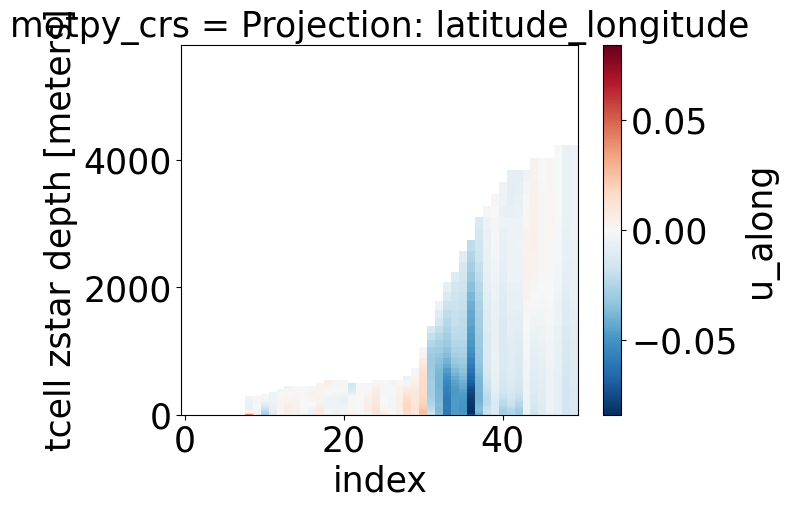

In [83]:
l = 3 # dense
## because of new crosssection method need to used plot_coord_list_test
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])
u_section.plot()

<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([-279.9, -279.8, -279.7, ...,   79.8,   79.9,   80. ])
Coordinates:
  * x        (x) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
Attributes:
    long_name:       ucell longitude
    units:           degrees_E
    cartesian_axis:  X
<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([80.1, 80.2, 80.3, ..., 79.8, 79.9, 80. ])
Coordinates:
  * x        (x) float64 29kB 80.1 80.2 80.3 80.4 80.5 ... 79.7 79.8 79.9 80.0
<xarray.DataArray 'u_along' (st_ocean: 75, y: 441, x: 3600)> Size: 476MB
dask.array<getitem, shape=(75, 441, 3600), dtype=float32, chunksize=(75, 441, 3600), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * y          (y) float64 4kB -80.0 -78.98 -78.93 ... -60.12 -60.07 -60.02
  * x          (x) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    metpy_crs  object 8B Projection: latitude_longitude
<xarray.DataArray 'u_along' (st_o

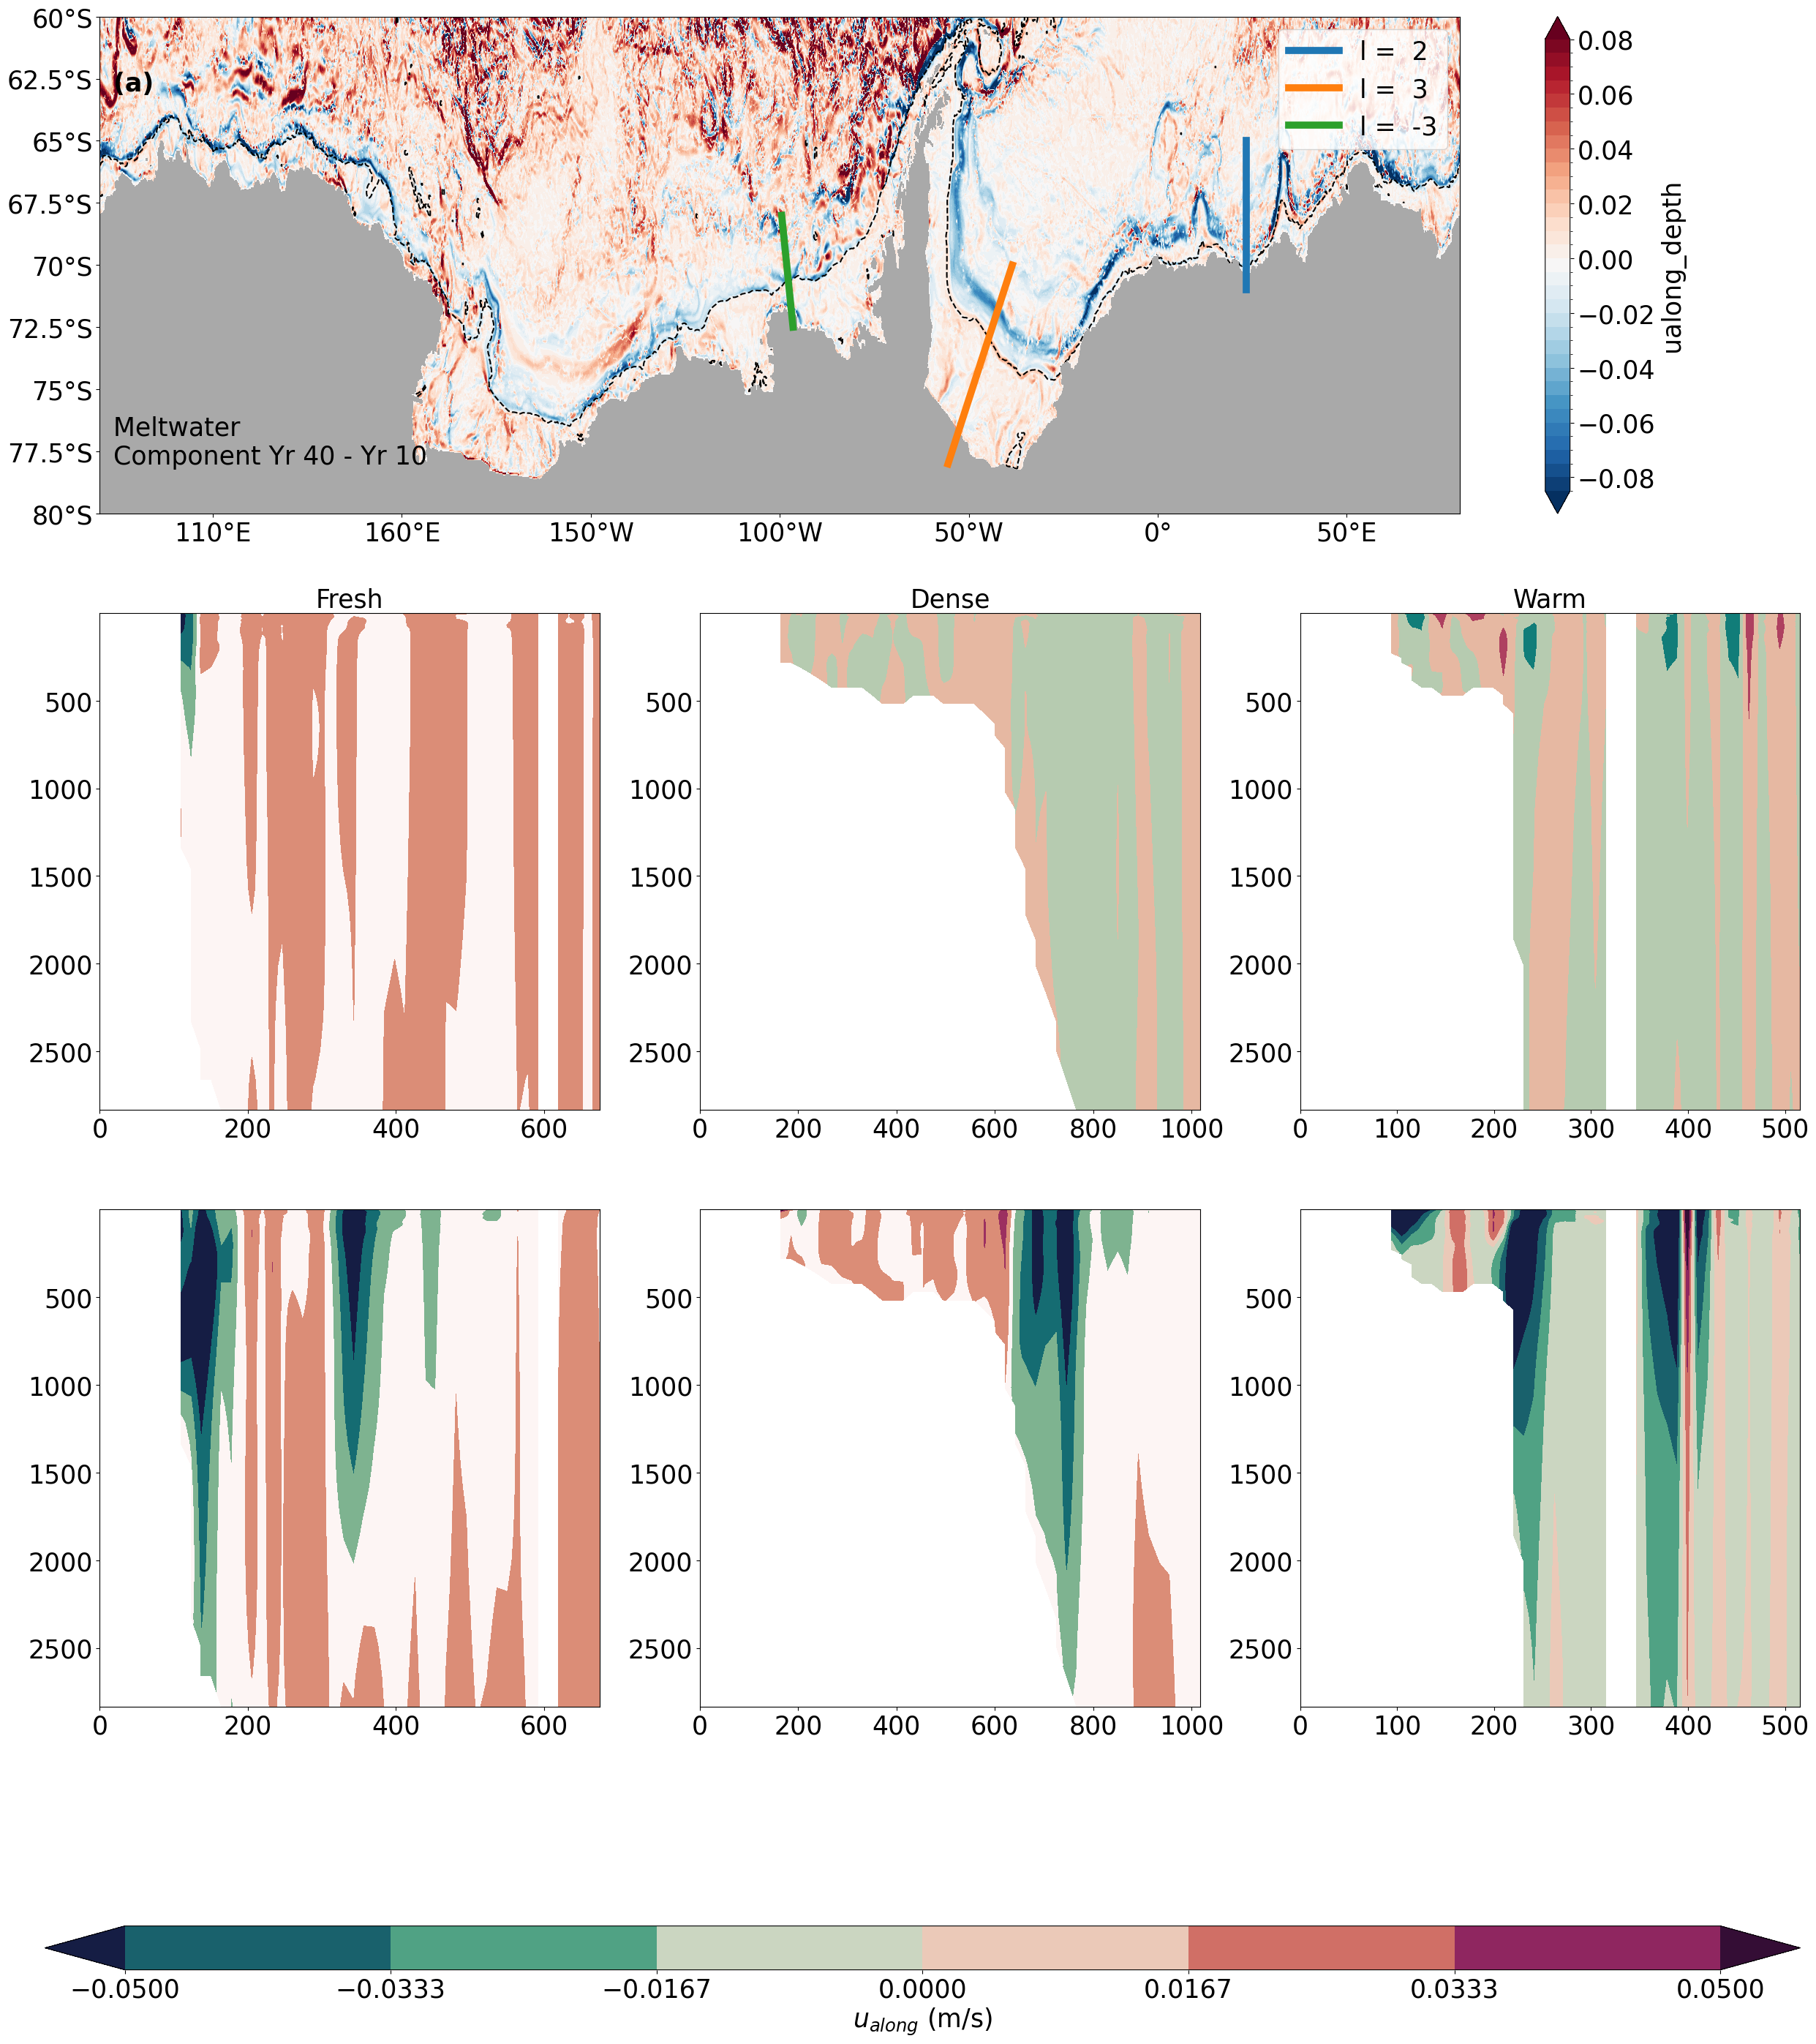

In [89]:
fig, ax = plt.subplot_mosaic("AAA;BCD;EFG", figsize = (30,30))
#count = 0
cmap = (u_barotropic.ualong_depth)\
            .plot.contourf(levels =levels_ualong, ax = ax['A'])
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax['A'], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax['A'].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax['A'].set_ylim([-80,-60])
ax['A'].text(0.01,0.1,'Meltwater \nComponent Yr 40 - Yr 10',transform=ax['A'].transAxes)
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ax['A'].text(0.01,0.85,'(a)', transform=ax['A'].transAxes, fontweight = 'bold')
for l in [2,3,-3]:
    ax['A'].plot( [plot_coord_list_test[l][1],plot_coord_list_test[l][3]], [plot_coord_list_test[l][0], plot_coord_list_test[l][2]]
                 , lw = 7, label = 'l =  '+ str(l))
ax['A'].legend() #plot_coord_list_test[l][:2], plot_coord_list_test[l][2:]

#cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
#cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', location = 'right', cax = cb_ax, pad = 0.01)
#cbar.set_ticks(np.arange(-0.1,0.125,0.025))

ax['A'].yaxis.set_major_formatter(LatitudeFormatter())
ax['A'].xaxis.set_major_formatter(LongitudeFormatter())


## Year 10 row
ualong_mw_year = u_alongdepth_wthmp.isel(year = 10) - u_alongdepth_wthp.isel(year = 10)
l = 2 # denman
## because of new crosssection method need to used plot_coord_list_test
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False, ax = ax['B'])
ax['B'].set_title('Fresh')
                  
l = 3 # dense
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['C'])
ax['C'].set_title('Dense')

l = -3 # amundsen
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['D'])
ax['D'].set_title('Warm')


## Year 49 row
ualong_mw_year = u_alongdepth_wthmp.isel(year = 49) - u_alongdepth_wthp.isel(year = 49)
l = 2 # denman
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['E'])

l = 3 # dense
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['F'])

l = -3 # amundsen
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

cmap = u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.curl, vmin=-0.05, vmax=0.05, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['G'])
# cbar_kwargs={'extend':'both','label':'Along-slope velocity (m s$^{-1}$)'}

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar_kwargs={'extend':'both','label':'Along-slope velocity (m s$^{-1}$)'}
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax,
                    pad = 0.01)


In [46]:
l = 5
[plot_coord_list_test[l][1],plot_coord_list_test[l][3]], [plot_coord_list_test[l][0], plot_coord_list_test[l][2]]

([43.5, 46.5], [-68.0, -63.0])

<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([-279.9, -279.8, -279.7, ...,   79.8,   79.9,   80. ])
Coordinates:
  * x        (x) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
Attributes:
    long_name:       ucell longitude
    units:           degrees_E
    cartesian_axis:  X
<xarray.DataArray 'x' (x: 3600)> Size: 29kB
array([80.1, 80.2, 80.3, ..., 79.8, 79.9, 80. ])
Coordinates:
  * x        (x) float64 29kB 80.1 80.2 80.3 80.4 80.5 ... 79.7 79.8 79.9 80.0
<xarray.DataArray 'u_along' (st_ocean: 75, y: 441, x: 3600)> Size: 476MB
dask.array<getitem, shape=(75, 441, 3600), dtype=float32, chunksize=(75, 441, 3600), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * y          (y) float64 4kB -80.0 -78.98 -78.93 ... -60.12 -60.07 -60.02
  * x          (x) float64 29kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    metpy_crs  object 8B Projection: latitude_longitude
<xarray.DataArray 'u_along' (st_o

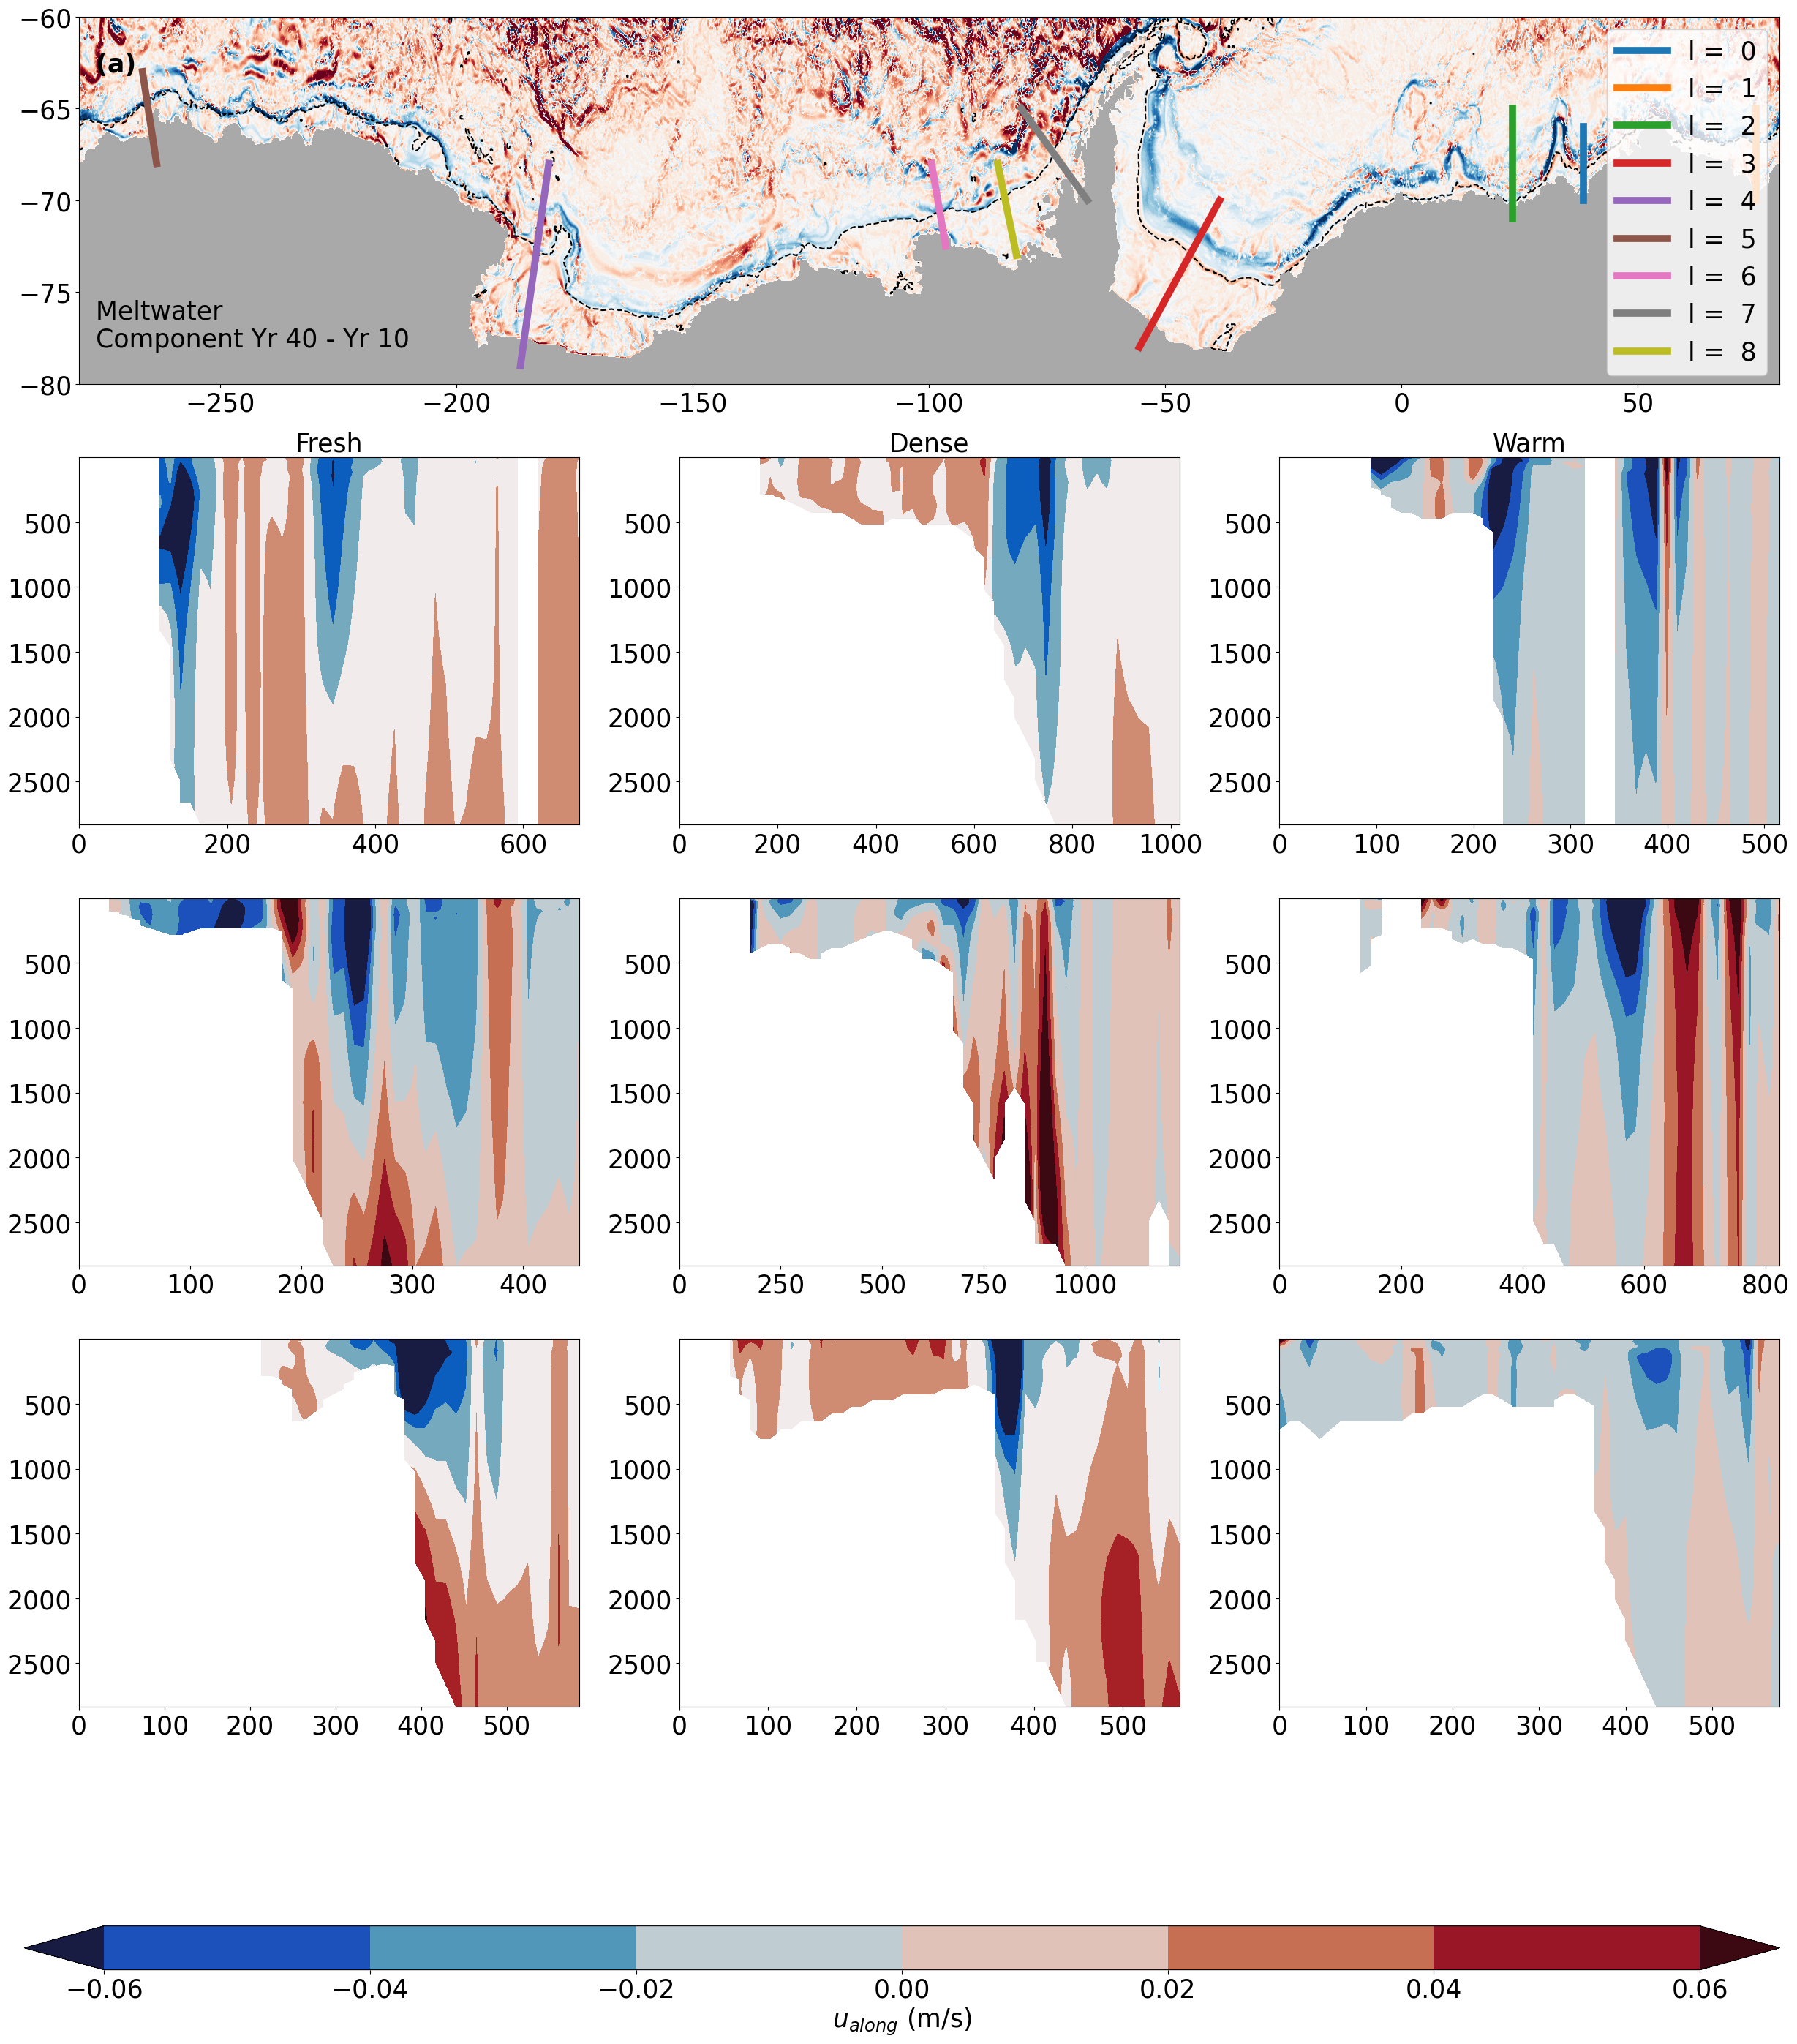

In [56]:
fig, ax = plt.subplot_mosaic("AAA;BCD;EFG;HIJ", figsize = (30,30))
#count = 0
cmap = (u_barotropic.ualong_depth)\
            .plot.contourf(levels =levels_ualong, ax = ax['A'], add_colorbar = False)
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax['A'], linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax['A'].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax['A'].set_ylim([-80,-60])
ax['A'].text(0.01,0.1,'Meltwater \nComponent Yr 40 - Yr 10',transform=ax['A'].transAxes)
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ax['A'].text(0.01,0.85,'(a)', transform=ax['A'].transAxes, fontweight = 'bold')
for l in range(len(plot_coord_list_test)):# [2,3,-3,0,5,-2]:
    ax['A'].plot( [plot_coord_list_test[l][1],plot_coord_list_test[l][3]], [plot_coord_list_test[l][0], plot_coord_list_test[l][2]]
                 , lw = 7, label = 'l =  '+ str(l))
ax['A'].legend() #plot_coord_list_test[l][:2], plot_coord_list_test[l][2:]

## Year 49 row
ualong_mw_year = u_alongdepth_wthmp.isel(year = 49) - u_alongdepth_wthp.isel(year = 49)
l = 2 # denman
## because of new crosssection method need to used plot_coord_list_test
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False, ax = ax['B'])
ax['B'].set_title('Fresh')
                  
l = 3 # dense
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['C'])
ax['C'].set_title('Dense')

l = -3 # amundsen
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['D'])
ax['D'].set_title('Warm')


l = 0 # 
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['E'])

l = 4 # dense
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['F'])

l = -2 # amundsen
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

cmap = u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['G'])
# cbar_kwargs={'extend':'both','label':'Along-slope velocity (m s$^{-1}$)'}

l = 5 # EA? 
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['H'])

l = 1 # dense
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['I'])

l = -1 # amundsen
u_section = generate_cross_section(ualong_mw_year, plot_coord_list_test[l][:2], plot_coord_list_test[l][2:])

cmap = u_section.sel(st_ocean= slice(0,3000)).plot.contourf(x='distance', y='st_ocean',
                          cmap=cm.cm.balance, vmin=-0.06, vmax=0.06, 
                          yincrease=False, add_labels=False,add_colorbar = False,  ax = ax['J'])
# cbar_kwargs={'extend':'both','label':'Along-slope velocity (m s$^{-1}$)'}
cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar_kwargs={'extend':'both','label':'Along-slope velocity (m s$^{-1}$)'}
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax,
                    pad = 0.01)
